In [1]:
import numpy as np  
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img  
from keras.models import Sequential  
from keras.layers import Dropout, Flatten, Dense  
from keras import applications  
from keras.utils.np_utils import to_categorical  
import matplotlib.pyplot as plt  
import math  

# dimensions of our images 
img_width, img_height = 224, 224  

weights_path = 'mobilenet_model.h5'  
train_data_dir = 'train_val_test/train'  
validation_data_dir = 'train_val_test/val'  
test_data_dir = 'train_val_test/test'  
   
 # number of epochs to train top model  
epochs = 50  
 # batch size used by flow_from_directory and predict_generator  
batch_size = 8  

Using TensorFlow backend.


In [2]:
model = applications.mobilenet.MobileNet(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255)  
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = model.predict_generator(  
     generator, predict_size_train)  
   
np.save('bottleneck_features_train_mob.npy', bottleneck_features_train)  

C:\Users\juigu\Anaconda2\envs\Python3\lib\site-packages\keras_applications\mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Found 8185 images belonging to 120 classes.


In [3]:
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = model.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation_mob.npy', bottleneck_features_validation) 

Found 1015 images belonging to 120 classes.


In [4]:
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
 # load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train_mob.npy')  
   
 # get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes)  

Found 8185 images belonging to 120 classes.


In [5]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation_mob.npy')  
   
validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

Found 1015 images belonging to 120 classes.


In [6]:
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  
   
model.compile(optimizer='rmsprop',  
              loss='categorical_crossentropy', metrics=['accuracy'])  
   
history = model.fit(train_data, train_labels,  
          epochs=epochs,  
          batch_size=batch_size,  
          validation_data=(validation_data, validation_labels))  
   
model.save_weights(weights_path)  
   
(eval_loss, eval_accuracy) = model.evaluate(  
     validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss)) 

Train on 8185 samples, validate on 1015 samples
Epoch 1/50
8185/8185 [==============================] - 319s 39ms/step - loss: 15.9167 - acc: 0.0105 - val_loss: 15.9911 - val_acc: 0.0079
Epoch 2/50
8185/8185 [==============================] - 207s 25ms/step - loss: 15.9190 - acc: 0.0106 - val_loss: 15.7230 - val_acc: 0.0187
Epoch 3/50
8185/8185 [==============================] - 189s 23ms/step - loss: 15.8003 - acc: 0.0177 - val_loss: 15.6320 - val_acc: 0.0296
Epoch 4/50
8185/8185 [==============================] - 215s 26ms/step - loss: 15.7088 - acc: 0.0225 - val_loss: 15.6266 - val_acc: 0.0286
Epoch 5/50
8185/8185 [==============================] - 219s 27ms/step - loss: 15.6778 - acc: 0.0254 - val_loss: 15.5459 - val_acc: 0.0315
Epoch 6/50
8185/8185 [==============================] - 215s 26ms/step - loss: 15.5668 - acc: 0.0321 - val_loss: 15.3410 - val_acc: 0.0443
Epoch 7/50
8185/8185 [==============================] - 215s 26ms/step - loss: 15.4682 - acc: 0.0379 - val_loss: 15.26

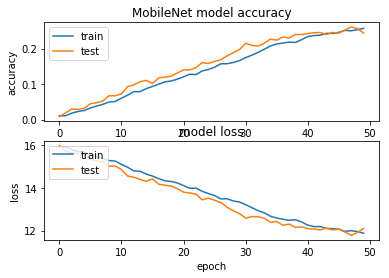

In [7]:
# summarize history for accuracy  
   
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('MobileNet model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
  
# summarize history for loss  
   
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show() 